In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

#### [0~14]을 윈도우로 분리

In [42]:
n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window : window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)

In [43]:
for index, (X_batch, Y_batch) in enumerate(dataset):
  print("===============",f"\n{index+1})", f"Batch {index}",  f"\n   X_batch\n{X_batch.numpy()}")
  print("ㅡㅡㅡㅡㅡㅡㅡ", f"\n   Y_batch\n{Y_batch.numpy()}")

1) Batch 0 
   X_batch
[[ 0  1  2  3]
 [10 11 12 13]
 [ 8  9 10 11]]
ㅡㅡㅡㅡㅡㅡㅡ 
   Y_batch
[[ 1  2  3  4]
 [11 12 13 14]
 [ 9 10 11 12]]
2) Batch 1 
   X_batch
[[6 7 8 9]
 [4 5 6 7]
 [2 3 4 5]]
ㅡㅡㅡㅡㅡㅡㅡ 
   Y_batch
[[ 7  8  9 10]
 [ 5  6  7  8]
 [ 3  4  5  6]]


#### 셰익스피어 작품 데이터

In [152]:
file_path = "https://raw.githubusercontent.com/ChaeWonIm0/MachineLearning_reference/main/Time_Series/shakespeare.txt"
file_path = keras.utils.get_file("shakespeare.txt", file_path)
with open(file_path) as f:
  shakespeare_text = f.read()

In [153]:
# 내용 확인
shakespeare_text[:200]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you'

In [154]:
# GRU로 쓸 토크나이저 정의
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [155]:
# 배열 > 글자 , 글자 > 배열
tokenizer.texts_to_sequences(["Second"]), tokenizer.sequences_to_texts([[8, 2, 19, 4, 10, 13]])

([[8, 2, 19, 4, 10, 13]], ['s e c o n d'])

In [156]:
# 워드 갯수
max_id = len(tokenizer.word_index)
max_id

39

In [157]:
# 워드배열의 총 갯수
dataset_size = tokenizer.document_count
dataset_size

1115394

In [158]:
# 각 워드를 숫자로 변환
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) -1
# [encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text]))
[encoded]

[array([19,  5,  8, ..., 20, 26, 10])]

In [159]:
# 학습셋 분리
train_size = dataset_size * 90 // 100
train_size

1003854

In [160]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

#### 긴 sequences를 그보다 작은 window로 변환

In [161]:
# 타겟
n_steps = 100
window_length = n_steps +1
dataset = dataset.window(window_length, shift = 1, drop_remainder = True)
dataset

<_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>

In [162]:
# 데이터 평탄화
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset

<_FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [163]:
# batch 사이즈
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:,:-1], windows[:, 1:]))
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [164]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [165]:
# 프리패치 추가
dataset = dataset.prefetch(1)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 39), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [166]:
# 사이즈 확인
for x,y in dataset.take(1):
  print(f"X 배치 텐서 : {x.shape}, Y 배치 텐서 {y.shape}")

X 배치 텐서 : (32, 100, 39), Y 배치 텐서 (32, 100)


#### 모델 로드

In [167]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
# 128층 인풋, DROPOUT은 GPU 사용시 쓰이지 않기 때문에 삭제

In [171]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [172]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, None, 128)         64896     
                                                                 
 gru_11 (GRU)                (None, None, 128)         99072     
                                                                 
 time_distributed_5 (TimeDis  (None, None, 39)         5031      
 tributed)                                                       
                                                                 
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


In [173]:
# 모델 학습 1회
history = model.fit(dataset, epochs=1)

31368/31368 [==============================] - 433s 14ms/step - loss: 1.6091


In [174]:
# 전처리
def preprocess(text):
  X = np.array(tokenizer.texts_to_sequences(text)) - 1
  # X = np.array(tokenizer.texts_to_sequences(text))
  return tf.one_hot(X, max_id)

In [176]:
# 테스트
X_new = preprocess(["Who are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

'u'

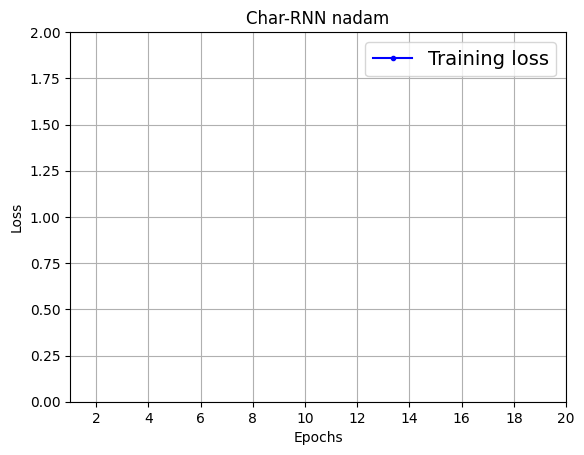

In [179]:
# loss 그래프 시각화
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"])
plt.title("Char-RNN nadam")
plt.show()

In [180]:
# 랜덤 생성
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]])

In [181]:
# 다음 글자를 예측하는 함수
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [183]:
next_char("where is h", temperature=1)

'o'

In [184]:
# 문자를 완성하는 함수
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [185]:
# 사용
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the world,
that she is so best the rest with her.




In [188]:
print(complete_text("t", temperature=0.5))

this gands,
he come to well and well i know her wor


# stateful RNN 로드


In [189]:
# Dataset 정리
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)


In [190]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [191]:
# 모델 설계
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [192]:
# state reset하는 콜백함수 정의
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [194]:
# Statefull RNN 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [195]:
# 모델 학습
history = model.fit(dataset, epochs=30,
                    callbacks=[ResetStatesCallback()])

Epoch 1/30
313/313 [==============================] - 8s 16ms/step - loss: 2.6236
Epoch 2/30
313/313 [==============================] - 8s 25ms/step - loss: 2.2492
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 2.1214
Epoch 4/30
313/313 [==============================] - 8s 26ms/step - loss: 2.0428
Epoch 5/30
313/313 [==============================] - 7s 22ms/step - loss: 1.9906
Epoch 6/30
313/313 [==============================] - 6s 18ms/step - loss: 1.9517
Epoch 7/30
313/313 [==============================] - 5s 17ms/step - loss: 1.9235
Epoch 8/30
313/313 [==============================] - 6s 20ms/step - loss: 1.9013
Epoch 9/30
313/313 [==============================] - 7s 22ms/step - loss: 1.8839
Epoch 10/30
313/313 [==============================] - 5s 16ms/step - loss: 1.8677
Epoch 11/30
313/313 [==============================] - 7s 22ms/step - loss: 1.8556
Epoch 12/30
313/313 [==============================] - 8s 25ms/step - loss: 1.8443
Epoch 13/30
3

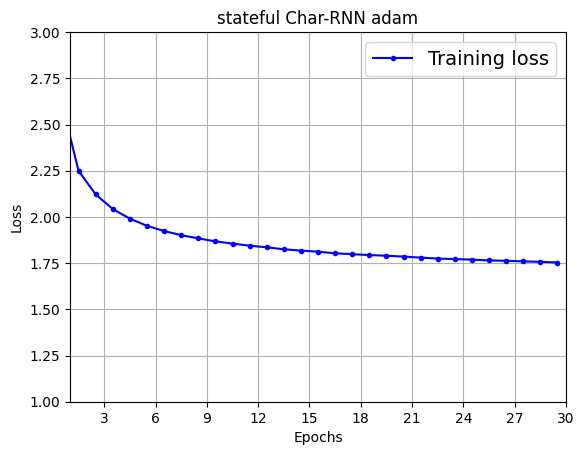

In [204]:
# loss 그래프 시각화
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 1, 3])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"])
plt.title("stateful Char-RNN adam")
plt.show()

In [197]:
# 상태가 없는 복사본 생성
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [198]:
# 모델 빌드

stateless_model.build(tf.TensorShape([None, None, max_id]))

In [199]:
# 가중치
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [205]:
# 검증
print(complete_text("t"), 0.2)

tor.

capulet:
he will fon out thore them: no, no w 0.2
